## 1. Task Target
### Description
<p>We are going to train two models to detect wether the inputed text/comment from the user is a hate/toxic text or not</p>

### Examples

## 2 Data information and methods used

### 2.1 Our Data files
<ol>
<li>all_data.csv</li>
<li>identity_individual_annotations.csv</li>
<li>sample_submission.csv</li>
<li>test.csv</li>
<li>test_private_expanded.csv</li>
<li>test_public_expanded.csv</li>
<li>toxicity_individual_annotations.csv</li>
<li>train.csv</li>
</ol>

All the datasets are from the Kaggle challenge "Jigsaw Unintended Bias in Toxicity Classification"<br>
link: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br>

### 2.3 Performance Metric

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>

### 2.4 Constraints

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

**Constraints:**
- The model should be fast to predict the toxicity rating.
- Interpretability is not needed.

## Importing libraries

In [100]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [102]:
from xgboost import XGBRegressor
# import gensim
import string
import tensorflow as tf

In [103]:
# import keras
# from keras.callbacks import ModelCheckpoint
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import CuDNNLSTM
# from keras.layers import Dropout
# from keras.layers.embeddings import Embedding
# import warnings
# from keras import backend as K
# warnings.filterwarnings("ignore")
# # K.tensorflow_backend._get_available_gpus()

## Reading Data

In [104]:
train_df = pd.read_csv('./data/train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [105]:
test_df = pd.read_csv('./data/test.csv', index_col='id', engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [106]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [130]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399743
atheist                                1399743
bisexual                               1399743
black                                  1399743
buddhist                               1399743
christian                              1399743
female                                 1399743
heterosexual                           1399743
hindu                                  1399743
homosexual_gay_or_lesbian              1399743
intellectual_or_learning_disability    1399743
jewish                                 1399743
latino                                 1399743
male                                   1399743
muslim       

**we got 3 null values for the comment_text and 0 for the target** <br>
so let's drop the null values in the "comment_text" so we dont get errors in the future

In [125]:
train_df = train_df.dropna(subset=['comment_text'])

**check again**

In [133]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399743
atheist                                1399743
bisexual                               1399743
black                                  1399743
buddhist                               1399743
christian                              1399743
female                                 1399743
heterosexual                           1399743
hindu                                  1399743
homosexual_gay_or_lesbian              1399743
intellectual_or_learning_disability    1399743
jewish                                 1399743
latino                                 1399743
male                                   1399743
muslim       

**Well done, nice**

In [126]:
train_df.dtypes

target                                 float64
comment_text                            object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float64
jewish                                 float64
latino                                 float64
male                                   float64
muslim       

In [111]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis

C:\Users\peace\AppData\Local\Temp\ipykernel_15464\1942080608.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')


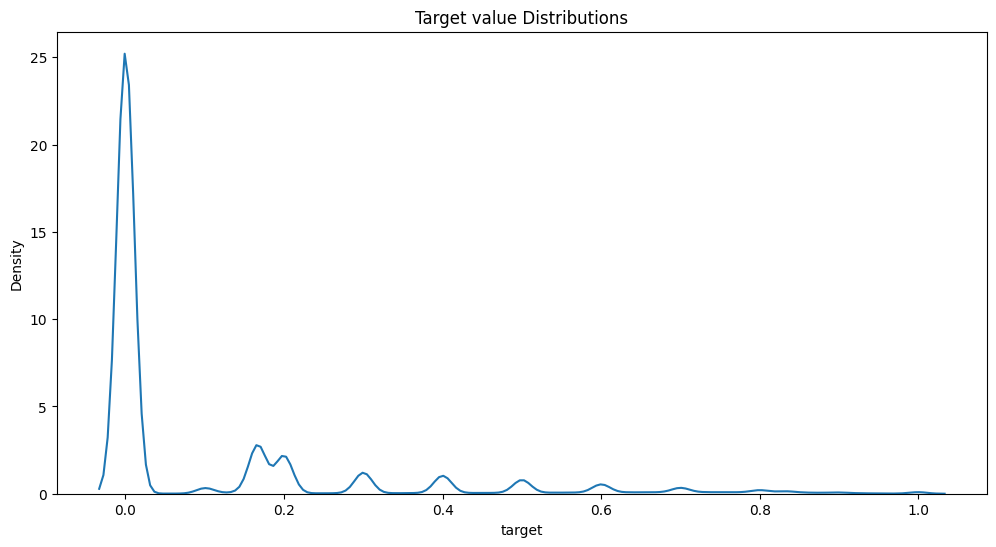

In [112]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

### Explore Subtype Features
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [113]:
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

C:\Users\peace\AppData\Local\Temp\ipykernel_15464\3540199171.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
C:\Users\peace\AppData\Local\Temp\ipykernel_15464\3540199171.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

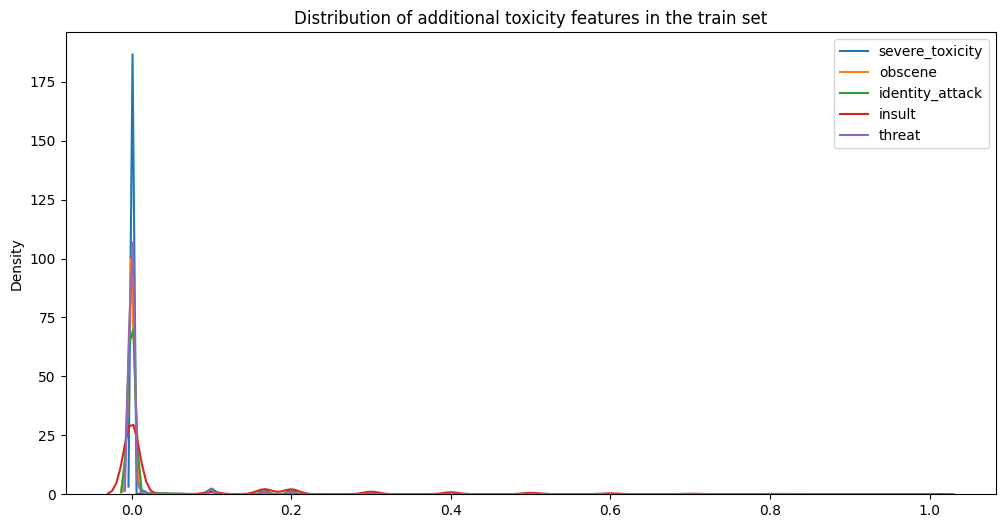

In [114]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

C:\Users\peace\AppData\Local\Temp\ipykernel_15464\3540199171.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
C:\Users\peace\AppData\Local\Temp\ipykernel_15464\3540199171.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

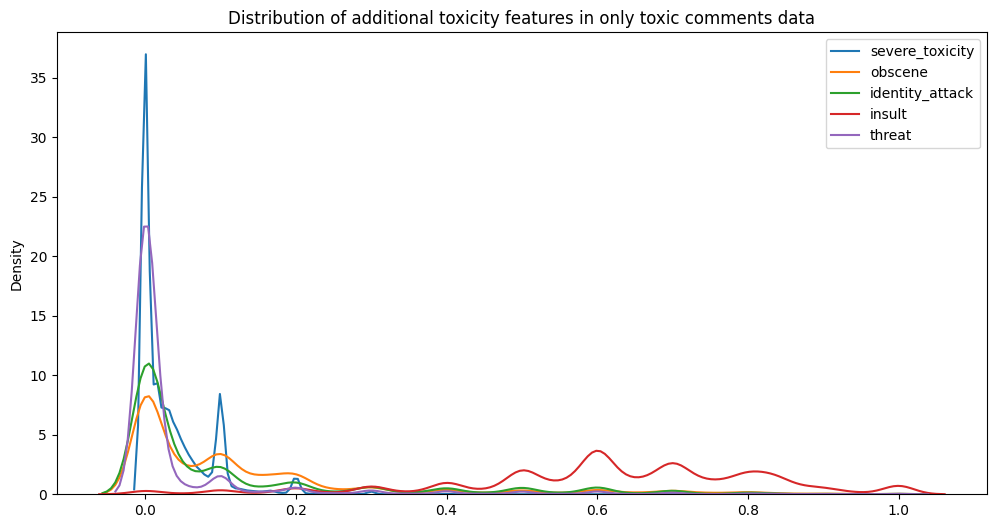

In [115]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [116]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

C:\Users\peace\AppData\Local\Temp\ipykernel_15464\466017331.py:14: UserWarning: The palette list has more values (44) than needed (5), which may not be intended.
  bars = sns.countplot(y=x, hue=x, order=order, palette=palette, ax=ax, legend=False)


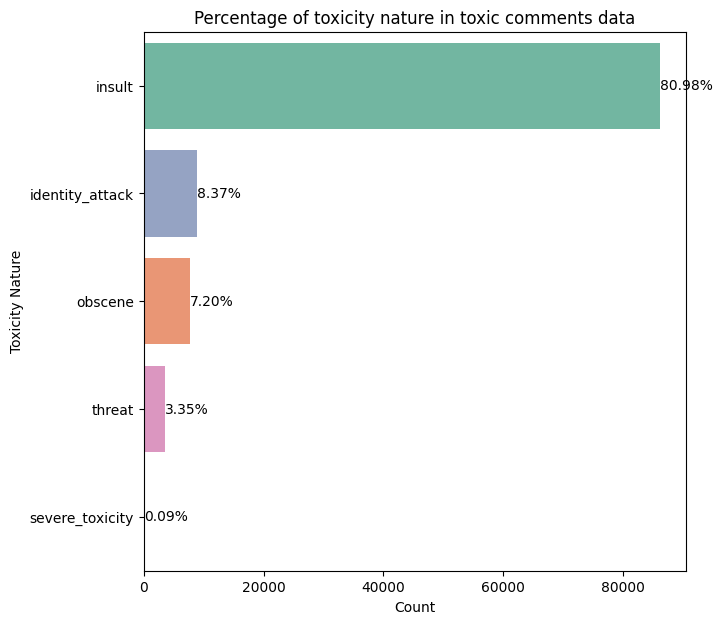

In [117]:
# Apply the get_comment_nature function to each row
x = temp.apply(get_comment_nature, axis=1) 

counts = x.value_counts()
order = x.value_counts().index

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
total = float(len(x))

# Set the palette to a different color scheme to distinguish between bars
palette = sns.color_palette("Set2", len(temp.columns))

# Plotting bars with aligned counts
bars = sns.countplot(y=x, hue=x, order=order, palette=palette, ax=ax, legend=False)

# Adding percentage labels on bars
for bar in bars.patches:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{width/total*100:.2f}%', va='center')

ax.set_title('Percentage of toxicity nature in toxic comments data')
ax.set_xlabel('Count')
ax.set_ylabel('Toxicity Nature')

plt.show()

# TODO: Check later if you need to add more EDA!

## Preprocessing Text and Train-Test Split:

In [118]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peace\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations

    x = text_string.split()
    new_text = []

    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))

    text_string = ' '.join(new_text)
    return text_string

**pre-proccess the TRAIN data**

In [129]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: total: 3min 53s
Wall time: 16min 49s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [135]:
train_df["preprocessed_text"].head(10)

id
59848     cool like would want mother read realli great ...
59849     thank would make life lot less anxieti induc k...
59852               urgent design problem kudo take impress
59855                         someth abl instal site releas
59856                                  haha guy bunch loser
59859                                     ur sh tti comment
59861                               hahahahahahahahhha suck
59863                                   ffffuuuuuuuuuuuuuuu
239575    rancher seem motiv most greed one right allow ...
239576                  great show combo expect good togeth
Name: preprocessed_text, dtype: object

**pre-proccess the TEST data**

In [123]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: total: 12 s
Wall time: 25.1 s


In [131]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353653, 1)
(451218, 1)
(1353653, 1)
(451218, 1)


In [132]:
X_train.head()

,preprocessed_text
id,
5537803,wow unprov specul masquerad insight anyth cons...
5748800,read need eras flat cheat
5048360,confus someon receiv spiritu help peopl receiv...
5478869,familiar term doubl point kealoha somewher are...
877417,interest march trump allow bill clinton rape w...


In [136]:
X_cv.head()

,preprocessed_text
id,
413097,interest 100 day gari besid honor thing gop ca...
384294,friend need learn fair use
5144072,hope educ way still write complet sentenc use ...
534082,sound like mani listen clinton scandal fear ma...
553809,csasurvivor thank speak need voic express shar...


In [137]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [138]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [ ]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')